In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import poisson
from scipy.stats import expon
from matplotlib.pyplot import figure

In [2]:
df = pd.read_csv("Datos_aseguradora.csv")
df['Fecha del Siniestro'] = pd.to_datetime(df['Fecha del Siniestro'], dayfirst=True)
df = df.sort_values(by='Fecha del Siniestro')
df

,Fecha del Siniestro,Tipo de auto,Modelo,Monto del siniestro,Aplica cobertura,Deducible,Reclamo de Cobertura,P�rdida total
16785,2020-01-01,Subcompacto,2016,15370,Si,2500.0,No,No
10717,2020-01-01,Subcompacto,2017,17590,Si,2500.0,No,No
17790,2020-01-01,Subcompacto,2016,16640,Si,2700.0,No,No
21959,2020-01-01,compacto,2017,22200,Si,3900.0,No,No
17787,2020-01-01,Camioneta,2017,82920,Si,8700.0,No,No
...,...,...,...,...,...,...,...,...
24341,2020-12-30,Camioneta,2017,50130,Si,6600.0,No,No
2921,2020-12-30,Austero,2017,7950,Si,1000.0,No,No
21560,2020-12-30,compacto,2018,22700,Si,3600.0,No,No
16250,2020-12-30,De Lujo,2016,41120,Si,5600.0,No,No


In [351]:
dias = df['Fecha del Siniestro'].unique()
dias.shape[0]

365

## Análisis exploratorio

In [352]:
# Obtenemos la cantidad de reclamos por dia
dias = df['Fecha del Siniestro'].unique()
n_reclamos = []
for i in dias:
    dia = df[df['Reclamo de Cobertura'] == 'Si'][df['Fecha del Siniestro'] == i][df['Aplica cobertura'] == 'Si']
    if dia.shape[0] != 0:
        n_reclamos.append(dia.shape[0])
    else:
        n_reclamos.append(0)
len(n_reclamos)

<ipython-input-352-d7da3d6ea961>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dia = df[df['Reclamo de Cobertura'] == 'Si'][df['Fecha del Siniestro'] == i][df['Aplica cobertura'] == 'Si']


365

## Estimación de parámetros

### Inferencia sobre el parametro lambda para el numero de reclamaciones

In [353]:
# Inferencia sobre el parametro lambda para el proceso de Poisson
lambda_poisson = np.mean(n_reclamos)
n_poisson = len(n_reclamos)
alpha = 0.05
lambda_down = lambda_poisson - stats.norm.isf(alpha/2)*np.sqrt(lambda_poisson/n_poisson)
lambda_up = lambda_poisson + stats.norm.isf(alpha/2)*np.sqrt(lambda_poisson/n_poisson)
print(lambda_poisson)
lambda_down, lambda_up

3.5452054794520547


(3.3520431808800297, 3.7383677780240796)

### Inferencia sobre la distribución de los montos de reclamo

In [354]:
#Calculamos betha en la distribución exponencial y su cantidad de datos
alpha = 0.05
aux = df[df['Monto del siniestro'] != 0]
num_datos = aux.shape[0]
betha_exp = np.mean(aux['Monto del siniestro'])
betha_exp

30774.779851021463

In [355]:
#Calculamos el intervalo de confianza
betha_down = 1/(chi2.ppf(1 - alpha/2, len(df['Monto del siniestro'])*2)/(2*np.sum(df['Monto del siniestro'])))
betha_up = 1/(chi2.ppf(alpha/2, len(df['Monto del siniestro'])*2)/(2*np.sum(df['Monto del siniestro'])))
betha_down,betha_up

(30408.414537209366, 31140.904917278556)

In [356]:
lambda_poisson*betha_exp

109102.91815677198

## Simulacion de una empresa aseguradora

In [357]:
def movimiento_capital(u,c,t,betha, lambda_p): ### Falta obtener el tiempo de la ruina
    tiempo = 365
    Z_list = [0]
    N_t = poisson.rvs(lambda_p,size=t)
    for i in range(1,t):
        Z_list.append(np.sum(np.random.exponential(betha,N_t[i])))
    suma_Z = [np.sum(Z_list[0:i+1]) for i in range(len(Z_list))]
    for i in range(len(suma_Z)):
        if u + c*i - suma_Z[i] <0:
            tiempo = i
            break
    return suma_Z,tiempo

In [362]:
def MonteCarloCrudo(beta,lambda_p):
    u = -1
    while u < 0:
        u = float(input('Ingresa el capital inicial: ', ))
    c = 0
    while c < beta*lambda_p:
        c = float(input('Ingresa la prima constante de la compañía: '))

    tiempos_ruinas = []
    prob_ruina = []

    for i in range(500):
        reclamos,t = movimiento_capital(u,c,365,beta,lambda_p)
        if t != 365:
            tiempos_ruinas.append(t)
            
            prob_ruina.append(len(tiempos_ruinas)/(i+1))
            

    ruins = len(tiempos_ruinas)

        
    estimacion = ruins/500
    print('Después de 10000 iteraciones, se tiene una probabilidad de ruina de:',estimacion)
    return estimacion, prob_ruina

In [363]:
est, pr =  MonteCarloCrudo(betha_exp,lambda_poisson)

Ingresa el capital inicial: 10000
Ingresa la prima constante de la compañía: 110000
Después de 10000 iteraciones, se tiene una probabilidad de ruina de: 0.956


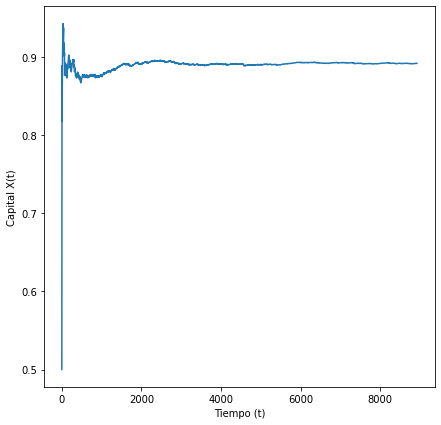

In [346]:
plt.figure(figsize=((7,7)))
plt.xlabel('Tiempo (t)')
plt.ylabel('Capital X(t)')
plt.plot(np.arange(0,len(pr)),pr)

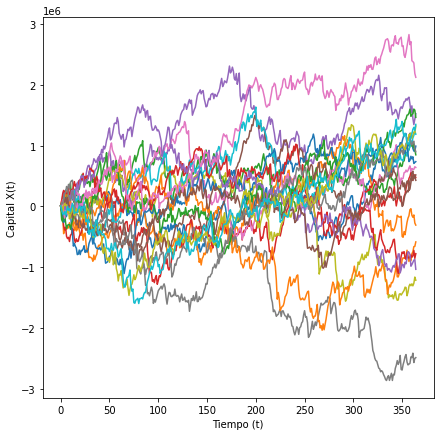

In [364]:
rec_list = []
for i in range(20):
    reclamos,t = movimiento_capital(10000,110000,365,betha_exp,lambda_poisson)
    rec_list.append(reclamos)
    
tiempo = np.arange(0,365)

x = []
for rec in rec_list:
    v = 10000 + 110000*tiempo - rec
    x.append(v)

plt.figure(figsize=((7,7)))
plt.xlabel('Tiempo (t)')
plt.ylabel('Capital X(t)')
for i in x:
    plt.plot(tiempo,i)

In [365]:
reclamos,t = movimiento_capital(10000,110000,365,betha_exp,lambda_poisson)
reclamos

[0,
 88363.1540780165,
 117318.99278340298,
 236527.6842387904,
 512207.44462994335,
 687536.3517353123,
 694655.0301769464,
 755756.0655108665,
 777460.6117133547,
 888510.2164603277,
 939095.365558352,
 1034428.7886313567,
 1341099.969658725,
 1589065.4394799878,
 1693591.4979739452,
 1754123.351900517,
 1913233.7321649287,
 2030760.9248543917,
 2230570.511391941,
 2320642.1897478113,
 2367281.709380066,
 2367281.709380066,
 2578717.6876822095,
 2671785.5756869614,
 2731104.4332819018,
 2796594.5662668017,
 3070560.9434153996,
 3318241.877929384,
 3447811.0974071124,
 3485923.8898746446,
 3587295.72714796,
 3644072.992153802,
 3736586.9267741707,
 3788578.521368543,
 3858098.4277665922,
 3875354.041223629,
 3942990.0530206044,
 4073175.3129583867,
 4073175.3129583867,
 4432083.205124041,
 4638398.2505398765,
 4704692.651457205,
 4796616.59372355,
 4934124.859047171,
 4979129.455792815,
 5127512.204454106,
 5266589.700499554,
 5352470.279902425,
 5447489.844477969,
 5652384.850071574,

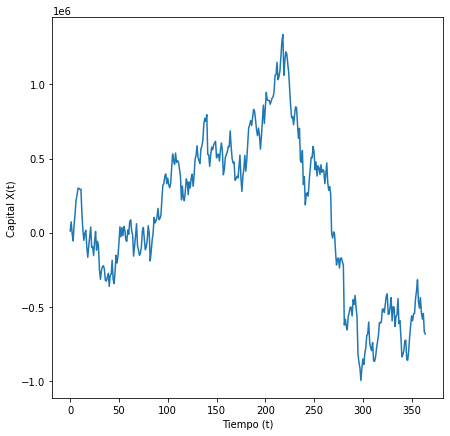

In [373]:
from matplotlib.pyplot import figure
reclamos,t = movimiento_capital(10000,110000,365,betha_exp,lambda_poisson)
tiempo = np.arange(0,365)

X = 10000 + 110000*tiempo - reclamos

plt.figure(figsize=((7,7)))
plt.xlabel('Tiempo (t)')
plt.ylabel('Capital X(t)')
plt.plot(tiempo,X)

In [235]:
tiempo = len(reclamos)
tiempo

365

In [236]:
np.arange(0,len(reclamos))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# ####################################################